In [33]:
import rasterio
import os
import json
import numpy as np
import geopandas as gpd

In [34]:
import rioxarray as rxr
from shapely.geometry import Polygon
import pysal as ps
import mapclassify as mc
import pyproj

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import contextily as cx
from shapely.geometry import Polygon
from mapclassify import classify

In [36]:
aoi = gpd.read_file('data/County_Boundary.geojson')

<AxesSubplot:>

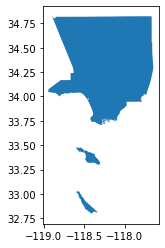

In [5]:
aoi.plot()

In [37]:
aoi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
hpi = gpd.read_file('data/HPI_Map_2021_11_03.geojson')

In [39]:
col = ['hpi2_pctile_pos', 'pct2010gq', 'hpi_least_healthy_25pct', 'quintiles', 'quartiles', 
           'economic_pctile', 'education_pctile', 'houseing_pctile', 'healthcareaccess_pctile', 
          'neighborhood_pctile', 'pollution_pctile', 'transportation_pctile', 'social_pctile', 
          'insured_pctile', 'uncrowded_pctile', 'homeownership_pctile', 'automobile_pctile', 
          'commute_pctile', 'inpreschool_pctile', 'inhighschool_pctile', 'bachelorsed_pctile', 
          'employed_pctile', 'abovepoverty_pctile', 'income_pctile', 'retail_pctile', 'parkaccess_pctile',
          'treecanopy_pctile', 'alcoffsale_pctile', 'voting_pctile', 'ownsevere_pctile', 'rentsevere_pctile',
          'houserepair_pctile', 'twoparents_pctile', 'supermkts_pctile', 'ozone_pctile', 'pm25_pctile',
          'dieselpm_pctile', 'h20contam_pctile', 'LEB_pctile']

In [55]:
hpi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8057 entries, 0 to 8056
Data columns (total 92 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   CensusTract              8057 non-null   object  
 1   pop2010                  8056 non-null   object  
 2   pct2010gq                8056 non-null   object  
 3   City                     8056 non-null   object  
 4   ZIP                      8056 non-null   object  
 5   County_FIPS              8056 non-null   object  
 6   County_Name              8056 non-null   object  
 7   UrbanType                8056 non-null   object  
 8   hpi2score                8056 non-null   object  
 9   hpi2_pctile_pos          8056 non-null   object  
 10  hpi_least_healthy_25pct  8056 non-null   object  
 11  quartiles                8056 non-null   object  
 12  quintiles                8056 non-null   object  
 13  economic                 8056 non-null   object  
 14  

In [77]:
hpi.dtypes

CensusTract         object
pop2010             object
pct2010gq           object
City                object
ZIP                 object
                    ...   
PacificIsl_pct      object
other_pct           object
version             object
notes               object
geometry          geometry
Length: 92, dtype: object

In [62]:
hpi_sub = hpi[['CensusTract', 'County_Name', 'pop2010', 'hpi2score', 'income', 'voting', 'supermkts','geometry']]

In [69]:
hpi_la_stng = hpi_sub[hpi_sub.County_Name=='Los Angeles']

In [78]:
hpi_la = hpi_la_stng.convert_dtypes()
print(hpi_la)

     CensusTract  County_Name pop2010    hpi2score  income       voting  \
0     6037139301  Los Angeles    4462  0.176188988   81867  58.75796178   
1     6037139302  Los Angeles    4422   -0.5976217   44104  66.20189626   
2     6037139502  Los Angeles    3007  0.248733799   62009  59.17012448   
3     6037139600  Los Angeles    4633  0.448743211   74212   74.3117181   
4     6037139701  Los Angeles    4920  0.755946854  124503  75.70285524   
...          ...          ...     ...          ...     ...          ...   
8048  6037192700  Los Angeles    3513  -0.58135518   37730  43.09123736   
8049  6037194500  Los Angeles    2037  0.255104821   76364  59.75614813   
8050  6037195100  Los Angeles    4717  0.626142938  128125  71.41472868   
8051  6037195300  Los Angeles    3203  0.337343276   68063  65.29926174   
8056  6037137501  Los Angeles    4124  0.207374489   80481  71.22240288   

        supermkts                                           geometry  
0     35.14777701  MULTIPOLY

In [79]:
hpi_la_wm = hpi_la.to_crs(epsg=3857)

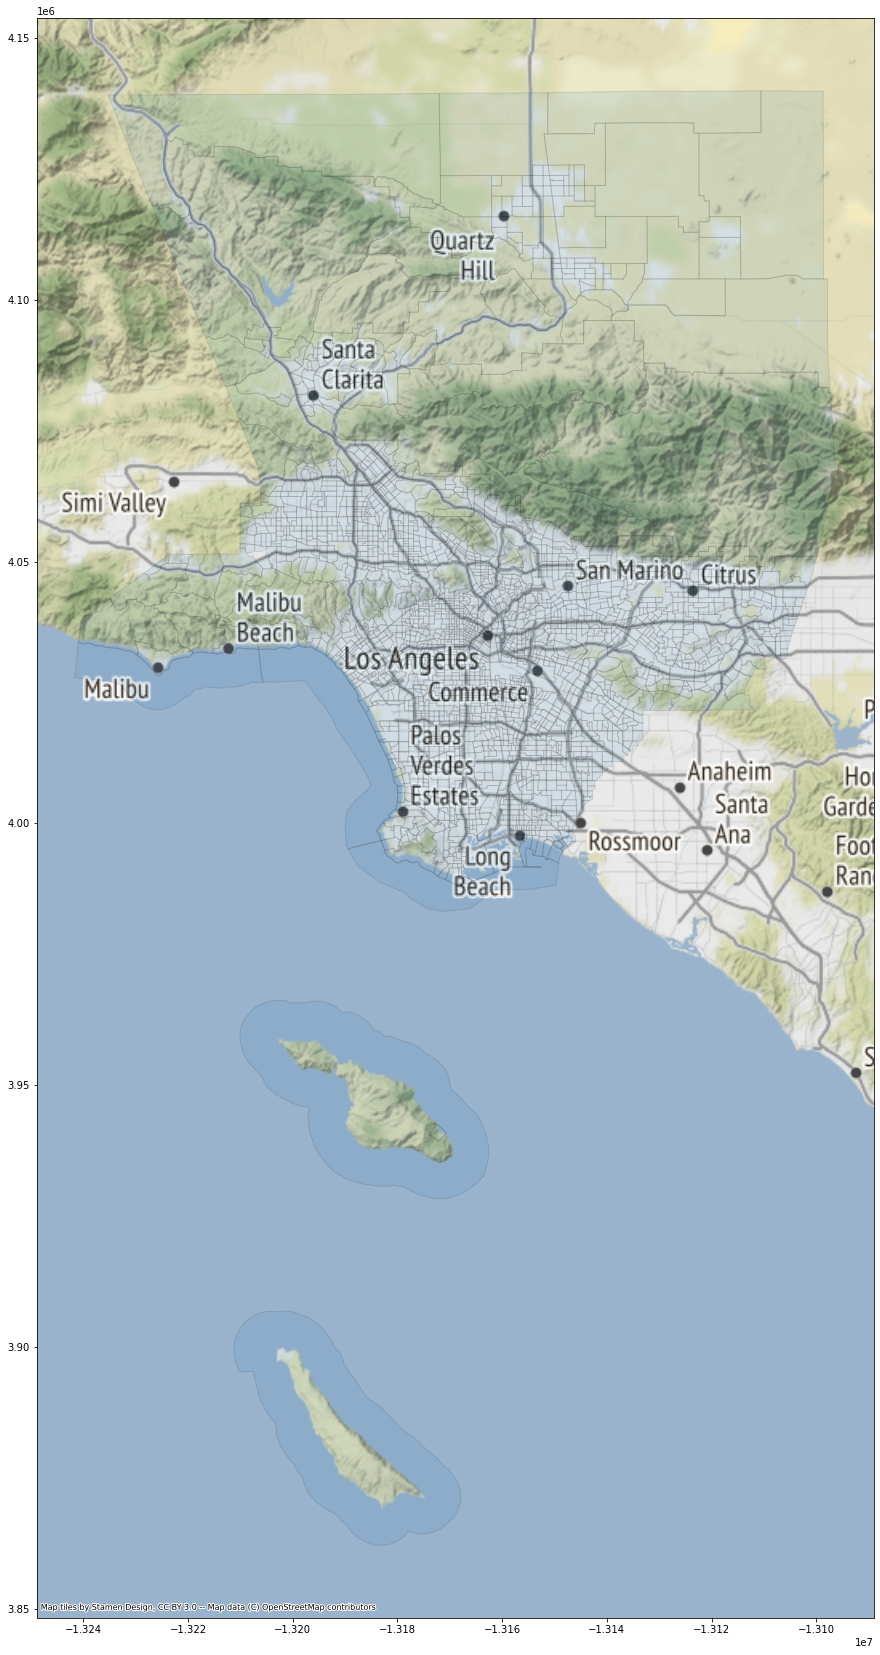

In [80]:
ax = hpi_la_wm.plot(figsize=(15, 45), alpha=0.1, edgecolor='k')
cx.add_basemap(ax)

<AxesSubplot:>

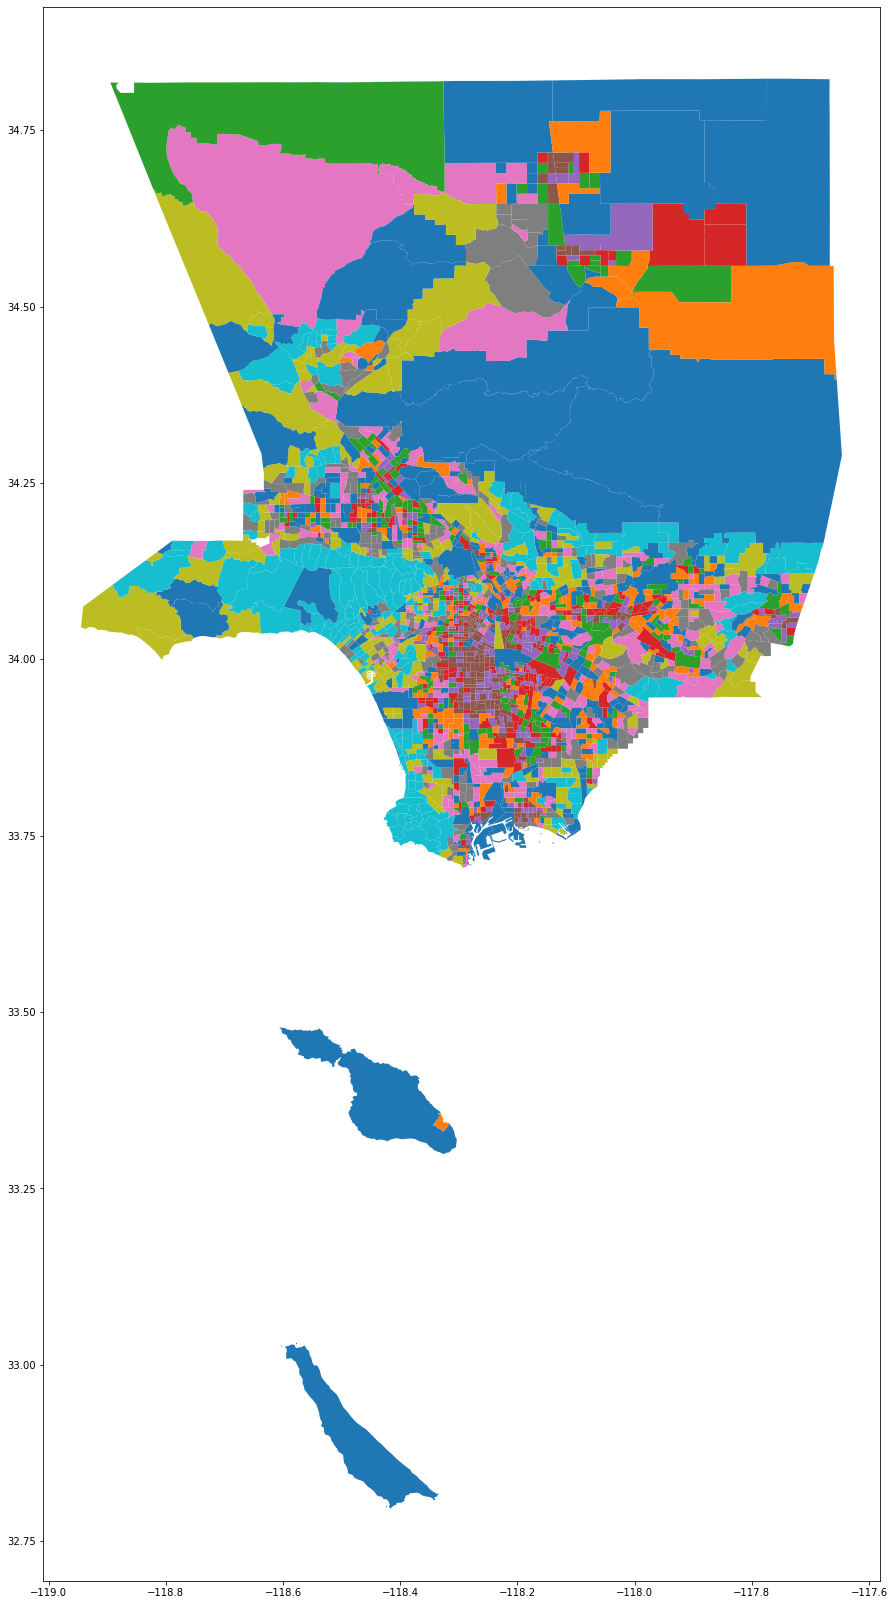

In [104]:
hpi_la.plot(column='hpi2score', categorical=False, figsize=(15, 45), legend=False)

In [92]:
# import plotly.express as px

# fig = px.choropleth(hpi_la,
#                    geojson=hpi_la.geometry,
#                    locations=hpi_la.index,
#                    color="hpi2score",
#                    projection="mercator")
# fig.update_geos(fitbounds="locations", visible=False)
# fig.show()

## Import raster data

In [81]:
data_pkg_path = 'data'
impv_dir = 'impv'
impv_file = 'NLCD_2019_Impervious_L48_20210604_rNuMWD3Z0SuUkIIVRc8K.tiff'
impv_path = os.path.join(data_pkg_path, impv_dir, impv_file)

In [82]:
impv = rxr.open_rasterio(impv_path)

In [83]:
land_dir = 'land'
land_file = 'NLCD_2019_Land_Cover_L48_20210604_rNuMWD3Z0SuUkIIVRc8K.tiff'
land_path = os.path.join(data_pkg_path, land_dir, land_file)

In [84]:
land = rxr.open_rasterio(land_path)

In [85]:
from pyproj import CRS

In [86]:
print(land.rio.crs.to_epsg())

None


In [87]:
print(land.rio.crs)

PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [88]:
print(land.rio.nodata)

None


In [89]:
print(land.rio.bounds())

(-2158455.0, 1280715.0, -1827435.0, 1591005.0)


In [90]:
print(land.rio.width)

11034


In [91]:
print(land.rio.height)

10343


In [92]:
print(np.percentile(land, 25))

0.0


In [94]:
dtm = rxr.open_rasterio('data/USGS_Elevation-m.tif')